Test the ConstructionBezier class for the procedure of contour and centerline generation.

In [54]:
'''
File used to create a 3D model of a Bezier curve tube, and then 
project that model onto the 2D image plane. This file is used each
time we create a new bezier curve (i.e. every run of the forward pass)
'''
import sys
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [1280, 800]
# mpl.rcParams['figure.dpi'] = 300

# sys.path.insert(1, '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
import camera_settings

import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
# from skimage.morphology import skeletonize
import skimage.morphology as skimage_morphology


from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from random import random, randrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
import os
import pdb
import argparse

class ConstructionBezier(nn.Module):
    
    def __init__(self, img_path, curve_length_gt, P0_gt, para_gt, para_init, loss_weight, total_itr, verbose=0):

        # self.img_id = 1
        # self.save_dir = './steps_imgs_left_1_STCF'
        # if os.path.isdir(self.save_dir):
        #     shutil.rmtree(self.save_dir)
        # os.mkdir(self.save_dir)
        # os.mkdir(self.save_dir + '/centerline')
        # os.mkdir(self.save_dir + '/contours')

        self.curve_length_gt = curve_length_gt
        self.P0_gt = P0_gt
        self.para_gt = para_gt
        self.para = para_init
        self.loss_weight = loss_weight
        self.total_itr = total_itr
        self.verbose = verbose

        self.OFF_SET = torch.tensor([0.00, 0.00, 0.00])

        # self.img_raw_skeleton = np.genfromtxt(
        #     "/home/fei/catheter_reconstruction_ws/saved_images_calibration_case1/seg_images_calibration_case1/seg_left_recif_1_skeleton.csv",
        #     delimiter=',')

        # img_path = "../exp_data_dvrk/seg_video5/seg_left_recif_0.png"
        downscale = 1.0
        # This doesn't make that big of a difference on synthetic images
        gaussian_blur_kern_size = 5
        dilate_iterations = 1

        # image size
        self.res_width = 640
        self.res_height = 480
        self.show_every_so_many_samples = 10
        self.R = 0.0013

        # camera E parameters
        cam_RT_H = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
        invert_y = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
        self.cam_RT_H = torch.matmul(invert_y, cam_RT_H)

        # camera I parameters
        self.cam_K = torch.tensor([[883.00220751, 0.0, 320.0], [0.0, 883.00220751, 240.0], [0, 0, 1.0]])
        self.cam_K = self.cam_K / downscale
        self.cam_K[-1, -1] = 1

        self.Fourier_order_N = 1

        raw_img_rgb = cv2.imread(img_path)
        # self.cam_distCoeffs = torch.tensor([-4.0444238705587998e-01, 5.8161897902897197e-01, -4.9797819387316098e-03, 2.3217574337593299e-03, -2.1547479006608700e-01])
        # raw_img_rgb_undst = cv2.undistort(raw_img_rgb, self.cam_K.detach().numpy(), self.cam_distCoeffs.detach().numpy())
        self.raw_img_rgb = cv2.resize(raw_img_rgb,
                                      (int(raw_img_rgb.shape[1] / downscale), int(raw_img_rgb.shape[0] / downscale)))
        self.raw_img = cv2.cvtColor(raw_img_rgb, cv2.COLOR_RGB2GRAY)

        # self.blur_raw_img = cv2.GaussianBlur(self.raw_img, (gaussian_blur_kern_size, gaussian_blur_kern_size), 0)
        # edges_img = canny(self.blur_raw_img, 2, 1, 100)
        # self.edges_img = cv2.dilate(edges_img.astype(np.uint8), np.ones((5, 5), np.uint8), iterations=dilate_iterations)

        # self.optimizer = torch.optim.SGD([self.para], lr=1e-5)
        self.optimizer = torch.optim.Adam([self.para], lr=1e-3)

        # self.optimal_R_EMraw2Cam = torch.tensor([[0.40533652, -0.91020415, 0.08503356],
        #                                          [0.86140179, 0.41142924, 0.29784715],
        #                                          [-0.30608701, -0.04748027, 0.95081879]])
        # self.optimal_t_EMraw2Cam = torch.tensor([[-0.120146], [-0.20414568], [0.22804266]])
        self.GD_Iteration = 0
        self.loss = None

        self.saved_opt_history = np.zeros((1, self.para.shape[0] + 1))

        ## get raw image skeleton
        self.getContourSamples()

        ## get ground truth 3D bezier curve
        self.pos_bezier_3D_gt = self.getAnyBezierCurve(self.para_gt, self.P0_gt)
        self.pos_bezier_3D_init = self.getAnyBezierCurve(para_init, self.P0_gt)

    
    def __init__(self, radius=0.0015): 
        '''
        Constructor to initialize the class with set curve & camera parameters
        Also, set manual seed for random number generation --> for reproducibility. 
        '''
        super().__init__()

        # self.fig = plt.figure()
        # self.ax = self.fig.add_subplot(111, projection='3d')
        self.epsilon = 1e-8

        # Number of samples to take along Bezier Curve
        self.num_samples = 30
        # self.num_samples = 6
        # Number of samples to take on INSIDE of each circle
        self.samples_per_circle = 20
        # self.samples_per_circle = 20
        # Number of samples to take on OUTSIDE border of each circle
        self.bezier_surface_resolution = 30
        # self.bezier_surface_resolution = 15
        self.bezier_circle_angle_increment = (2 * math.pi) / self.bezier_surface_resolution

        self.cylinder_mesh_points = torch.zeros(self.num_samples, self.samples_per_circle, 3)
        self.cylinder_surface_points = torch.zeros(self.num_samples, self.bezier_surface_resolution, 3)

        self.radius = radius
        # self.radius = 2
        # self.radius = 0.003

        self.setCameraParams(camera_settings.a, camera_settings.b, camera_settings.center_x, camera_settings.center_y,
                             camera_settings.image_size_x, camera_settings.image_size_y, camera_settings.extrinsics,
                             camera_settings.intrinsics)
        
        # Used to generate same set of random numbers each time (mainly used for getting random points in circles)
        torch.manual_seed(0)

    def setCameraParams(self, fx, fy, cx, cy, size_x, size_y, camera_extrinsics, camera_intrinsics):
        """
        Set intrinsic and extrinsic camera parameters

        Args:
            fx (float): horizontal direction focal length
            fy (float): vertical direction focal length
            cx (float): horizontal center of image
            cy (float): vertical center of image
            size_x (int): width of image
            size_y (int): height of image
            camera_extrinsics ((4, 4) numpy array): RT matrix 
            camera_intrinsics ((3, 3) numpy array): K matrix 
        """
        self.fx = fx
        self.fy = fy
        self.cx = cx
        self.cy = cy
        self.size_x = size_x
        self.size_y = size_y
        # self.cam_RT_H = torch.as_tensor(camera_extrinsics).float()
        self.cam_K = torch.as_tensor(camera_intrinsics)

        # camera E parameters
        cam_RT_H = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
        invert_y = torch.tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
        self.cam_RT_H = torch.matmul(invert_y, cam_RT_H)
    
    def isPointInImage(self, p_proj, width, height):
        '''
        Check if a projected point is within the image frame

        Args:
            p_proj (torch.tensor): projected point
            width (int): width of image
            height (int): height of image
        '''
        if torch.all(torch.isnan(p_proj)):
            # print('NaN')
            return False
        if p_proj[0] < 0 or p_proj[1] < 0 or p_proj[0] > width or p_proj[1] > height:
            # print('Out')
            return False

        return True

###################################################################################################
###################################################################################################
###################################################################################################

# Helper functions for plotting using matplotlib

    def set_axes_equal(self, ax: plt.Axes):
        """
        Set 3D plot axes to equal scale.

        Make axes of 3D plot have equal scale so that spheres appear as
        spheres and cubes as cubes.  Required since `ax.axis('equal')`
        and `ax.set_aspect('equal')` don't work on 3D.

        Args:
            ax (plt.Axes): Matplotlib axes to set equal.
        """
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis=1)
        radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
        self._set_axes_radius(ax, origin, radius)

    def _set_axes_radius(self, ax, origin, radius):
        '''
        Set axes radius. Works in conjunction with set_axes_equal. 

        Args:
            ax (plt.Axes): Matplotlib axes to set equal.
            origin (np.array): origin of axes
            radius (float): radius of axes
        '''

        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])

###################################################################################################
###################################################################################################
###################################################################################################

# Helper functions for obtaining the tangent, normal and binormal vectors of a bezier curve

    def getBezierTNB(self, bezier_pos, bezier_der, bezier_snd_der):
        '''
        Get the tangent, normal and binormal vectors of a bezier curve. 
        Add self.epsilon to the denominator to avoid division by zero (to avoid
        getting NaN values in the tensors).

        Args:
            bezier_pos (torch.tensor): bezier curve points
            bezier_der (torch.tensor): bezier curve first derivative
            bezier_snd_der (torch.tensor): bezier curve second derivative
        '''

        bezier_der_n = torch.linalg.norm(bezier_der, ord=2, dim=1)
        # self.bezier_tangent = bezier_der / torch.unsqueeze(bezier_der_n, dim=1)

        bezier_normal_numerator = torch.linalg.cross(bezier_der, torch.linalg.cross(bezier_snd_der, bezier_der))
        bezier_normal_numerator_n = torch.mul(
            bezier_der_n, torch.linalg.norm(torch.linalg.cross(bezier_snd_der, bezier_der), ord=2, dim=1))

        bezier_normal = bezier_normal_numerator / (torch.unsqueeze(bezier_normal_numerator_n, dim=1) + self.epsilon)

        bezier_binormal_numerator = torch.linalg.cross(bezier_der, bezier_snd_der)
        bezier_binormal_numerator_n = torch.linalg.norm(bezier_binormal_numerator, ord=2, dim=1)

        bezier_binormal = bezier_binormal_numerator / (torch.unsqueeze(bezier_binormal_numerator_n, dim=1) + self.epsilon)

        print("bezier_normal: " + str(bezier_normal))
        print("bezier_binormal" + str(bezier_binormal))

        # pdb.set_trace()

        assert not torch.any(torch.isnan(bezier_normal))
        assert not torch.any(torch.isnan(bezier_binormal))

    def getBezierNormal(self, bezier_der, bezier_snd_der): 
        '''
        Get the normal vector of a bezier curve.
        Add self.epsilon to the denominator to avoid division by zero (to avoid
        getting NaN values in the tensors).

        Args:
            bezier_der (torch.tensor): bezier curve first derivative
            bezier_snd_der (torch.tensor): bezier curve second derivative

        '''
        bezier_der_n = torch.linalg.norm(bezier_der, ord=2, dim=1)
        # self.bezier_tangent = bezier_der / torch.unsqueeze(bezier_der_n, dim=1)

        bezier_normal_numerator = torch.linalg.cross(bezier_der, torch.linalg.cross(bezier_snd_der, bezier_der))
        bezier_normal_numerator_n = torch.mul(
            bezier_der_n, torch.linalg.norm(torch.linalg.cross(bezier_snd_der, bezier_der), ord=2, dim=1))

        bezier_normal = bezier_normal_numerator / (torch.unsqueeze(bezier_normal_numerator_n, dim=1) + self.epsilon)

        # print("bezier_normal: " + str(bezier_normal))

        # Throw an error if there are an NaN values in bezier_normal
        assert not torch.any(torch.isnan(bezier_normal))

        return bezier_normal
    
    def getBezierBinormal(self, bezier_der, bezier_snd_der): 
        '''
        Get the binormal vector of a bezier curve.
        Add self.epsilon to the denominator to avoid division by zero (to avoid
        getting NaN values in the tensors).

        Args:
            bezier_der (torch.tensor): bezier curve first derivative
            bezier_snd_der (torch.tensor): bezier curve second derivative
        '''
        bezier_binormal_numerator = torch.linalg.cross(bezier_der, bezier_snd_der)
        bezier_binormal_numerator_n = torch.linalg.norm(bezier_binormal_numerator, ord=2, dim=1)

        bezier_binormal = bezier_binormal_numerator / (torch.unsqueeze(bezier_binormal_numerator_n, dim=1) + self.epsilon)

        # print("bezier_binormal" + str(bezier_binormal))

        # Throw an error if there are an NaN values in bezier_binormal
        assert not torch.any(torch.isnan(bezier_binormal))

        return bezier_binormal

# Helper functions for obtaining normalized and translated versions of vectors

    def getNormalizedVectors(self, set_of_vectors): 
        '''
        Method to get the normalized version of a set of vectors (of the shape: (num_samples, 3)). 
        Calculates the L2 norm (cartesian magnitude) of each vector and divides by it. 
        When vector norm is zero, dividing the vector by its norm will result in NaN values 
        because division by zero is mathematically undefined. To avoid NaN values, add a small epsilon 
        value to the denominator before performing the division. 
        This will prevent division by exactly zero and keep the vectors valid. 

        Args:
            set_of_vectors (torch.tensor): set of vectors to normalize
        '''
        normalized_set_of_vectors = set_of_vectors / (torch.linalg.norm(set_of_vectors, ord=2, dim=0) + self.epsilon)
        return normalized_set_of_vectors

    def getTranslatedVectors(self, pos_bezier, set_of_vectors): 
        '''
        Method to get the translated version of a set of vectors (of the shape: (num_samples, 3)). 
        Adds respective point on Bezier curve to the vector (s.t. point is considered 'start' of translated vector). 

        Args:
            pos_bezier (torch.tensor): point on Bezier curve
            set_of_vectors (torch.tensor): set of vectors to translate
        '''
        translated_set_of_vectors = pos_bezier + set_of_vectors
        return translated_set_of_vectors


###################################################################################################
###################################################################################################
###################################################################################################

    # Functions for plotting the 3D Bezier curve (3d model vectors or 3d model cylinder) and 2D helpers

    def getRandCirclePoint(self, radius, center_point, normal_vec, binormal_vec): 
        '''
        Method to calculate random point on a circle in 3-dimensions. 

        Args: 
            radius (int): radius value of circle
            center_point (tensor): center point of circle; i.e., current point on Bezier curve
            normal_vec (tensor): normal vector at that point on Bezier curve
            binormal_vec (tensor): binormal vector at that point on Bezier curve
        '''
        rand_dist_from_center = radius * torch.sqrt(torch.rand(1))
        rand_angle = 2 * math.pi * torch.rand(1)

        rand_circle_point = center_point + rand_dist_from_center * (torch.cos(rand_angle)) * normal_vec + rand_dist_from_center * (torch.sin(rand_angle)) * binormal_vec

        return rand_circle_point

    def getCircleBorderPoint(self, radius, angle, center_point, normal_vec, binormal_vec):
        '''
        Method to calculate point on the border of a circle in 3-dimensions. 

        Args: 
            radius: radius value of circle
            center_point (tensor): center point of circle; i.e., current point on Bezier curve
            normal_vec: normal vector at that point on Bezier curve
            binormal_vec: binormal vector at that point on Bezier curve
        '''
        
        # Convert angle to a torch tensor to use torch's trig functions
        angle += torch.tensor(1)

        circle_border_point = center_point + radius * (torch.cos(angle)) * normal_vec + radius * (torch.sin(angle)) * binormal_vec

        return circle_border_point

    def plot3dPoints(self, show_vector_lines, plot_bezier_points, set_of_vectors=None): 
        '''
        Method to plot Bezier vectors using MatPlotLib. 
        NOTE: Plot will come out weird if using radius that is substantially larger than the 
        length of the actual curve. 

        Args: 
            pos_bezier (Tensor): Points along Bezier curve
            set_of_vectors (Tensor): Vectors (tangent, normal, binormal) along Bezier curve
            show_vector_lines (boolean): Boolean to show vector line between vector initial and terminal points
            plot_bezier_points (boolean): Boolean to plot points along Bezier curve
        '''
        # print("INSIDE pos_bezier: " + str(pos_bezier))
        # print("INSIDE set_of_vectors: " + str(set_of_vectors))

        # Only plot points along Bezier curve. No vector lines
        if plot_bezier_points is True and set_of_vectors is None and show_vector_lines is False: 
            for point in self.pos_bezier: 
                self.ax.scatter(point[0], point[1], point[2])

        # Only plot vector points. No vector lines
        elif plot_bezier_points is False and set_of_vectors is not None and show_vector_lines is False: 
            vec_normalized = self.getNormalizedVectors(set_of_vectors)
            vec_normalized_translated = self.getTranslatedVectors(self.pos_bezier, vec_normalized)

            for vec in vec_normalized_translated: 
                self.ax.scatter(vec[0], vec[1], vec[2])

        # Only plot vectors points. Show vector lines
        elif plot_bezier_points is False and set_of_vectors is not None and show_vector_lines is True:
            vec_normalized = self.getNormalizedVectors(set_of_vectors)
            vec_normalized_translated = self.getTranslatedVectors(self.pos_bezier, vec_normalized)
            
            for pos_vec, vec in zip(self.pos_bezier, vec_normalized_translated): 
                self.ax.scatter(vec[0], vec[1], vec[2])
                self.ax.plot([pos_vec[0], vec[0]], [pos_vec[1], vec[1]], [pos_vec[2], vec[2]])

        # Plot points along Bezier curve and vectors points. No vector lines
        elif plot_bezier_points is True and set_of_vectors is not None and show_vector_lines is False: 
            vec_normalized = self.getNormalizedVectors(set_of_vectors)
            vec_normalized_translated = self.getTranslatedVectors(self.pos_bezier, vec_normalized)

            for point, vec in zip(self.pos_bezier, vec_normalized_translated): 
                self.ax.scatter(point[0], point[1], point[2])
                self.ax.scatter(vec[0], vec[1], vec[2])

        # Plot points along Bezier curve and vectors points. Show vector lines
        elif plot_bezier_points is True and  set_of_vectors is not None and show_vector_lines is True: 
            vec_normalized = self.getNormalizedVectors(set_of_vectors)
            vec_normalized_translated = self.getTranslatedVectors(self.pos_bezier, vec_normalized)

            for point, vec in zip(self.pos_bezier, vec_normalized_translated): 
                self.ax.scatter(point[0], point[1], point[2])
                self.ax.scatter(vec[0], vec[1], vec[2])
                self.ax.plot([pos_vec[0], vec[0]], [pos_vec[1], vec[1]], [pos_vec[2], vec[2]])


    def run3dPlot(self): 
        '''
        Method to use in conjunction with plot3dPoints() to plot Bezier curve and TNB vectors.
        '''

        self.ax.set_box_aspect([2,2,2]) 
        self.set_axes_equal(self.ax)

        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.fig.suptitle('Bézier Curve TNB Frames')

        plt.show()

    def plot3dBezierCylinder(self): 
        '''
        Method to plot 3D cylinder mesh points using MatPlotLib.
        '''
        # Get Cylinder mesh points
        for i, (pos_vec) in enumerate(self.pos_bezier): 
            for j in range(self.samples_per_circle + self.bezier_surface_resolution): 

                # Plot cylinder mesh points
                self.ax.scatter(pos_vec[0].detach().numpy() + self.cylinder_mesh_and_surface_points[i, j, 0].detach().numpy(), 
                                pos_vec[1].detach().numpy() + self.cylinder_mesh_and_surface_points[i, j, 1].detach().numpy(), 
                                pos_vec[2].detach().numpy() + self.cylinder_mesh_and_surface_points[i, j, 2].detach().numpy())

        # Set up axes for 3d plot
        self.ax.set_box_aspect([2,2,2]) 
        self.set_axes_equal(self.ax)

        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.fig.suptitle('Bézier Curve - Cross Sectional Circles')

        plt.show()

    def get_raw_centerline_ref(self, img_ref): 
        '''
        Method to get the raw centerline of the catheter from the reference image.
        In this file, only used in draw2DCylinderImage() method to get the centerline 
        of the catheter in the reference image for show. 

        Args:
            img_ref (Tensor): Reference image of catheter
        '''

        # convert to numpy array
        img_ref = img_ref.cpu().detach().numpy().copy()

        img_height = img_ref.shape[0]
        img_width = img_ref.shape[1]

        # perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
        extend_dim = int(60)
        img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
        img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

        # get the left boundary of the image
        left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
        left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

        # get the center of the left boundary
        extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
        extend_vec_pt2_center = np.array(
            [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
        exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

        # avoid dividing by zero
        if exten_vec[1] == 0:
            exten_vec[1] += 0.00000001

        # get the slope and intercept of the line
        k_extend = exten_vec[0] / exten_vec[1]
        b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
        b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

        # extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
        # then it could be able to get the intersection point with boundary
        extend_ROI = np.array([
            np.array([img_width, left_boundarylineA_id[0]]),
            np.array([img_width, left_boundarylineA_id[-1]]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_up) / k_extend)])
        ])

        # fill the extended ROI with 1
        img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

        # skeletonize the image
        skeleton = skimage_morphology.skeletonize(img_thresh_extend)

        # get the centerline of the image
        img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

        self.img_raw_skeleton = torch.as_tensor(img_raw_skeleton).float()

###################################################################################################
###################################################################################################
###################################################################################################
# FROM diff-render directory: 
# Functions to get Bezier position points projected image 

    def loadRawImage(self, img_path):
        raw_img_rgb = cv2.imread(img_path)
        self.img_ownscale = 1.0
        self.raw_img_rgb = cv2.resize(
            raw_img_rgb, (int(raw_img_rgb.shape[1] / self.img_ownscale), int(raw_img_rgb.shape[0] / self.img_ownscale)))
        self.raw_img_gray = cv2.cvtColor(raw_img_rgb, cv2.COLOR_RGB2GRAY)

    def getBezierProjImg(self, pos_bezier=None, der_bezier=None, double_der_bezier=None):
        '''
        Convert positions, tangents, normals to camera frame

        Args:
            pos_bezier (Tensor): 3D positions of bezier curve
            der_bezier (Tensor): 3D tangents of bezier curve
            double_der_bezier (Tensor): 3D normals of bezier curve
        '''

        # TODO: convert 3d world cyinder mesh points to camera frame

        # Convert 3D world position to camera frame
        pos_bezier_H = torch.cat((self.pos_bezier, torch.ones(self.num_samples, 1)), dim=1)

        bezier_pos_cam_H = torch.transpose(torch.matmul(self.cam_RT_H, torch.transpose(pos_bezier_H, 0, 1)), 0, 1)
        # self.bezier_pos_cam = bezier_pos_cam_H[1:, :-1]  ## without including the first point

        # :-1 needed to remove homogeneous coord from each 3d point
        self.bezier_pos_centerline_cam = bezier_pos_cam_H[:, :-1]


        # Changed self.bezier_pos_centerline_cam[1:] to self.bezier_pos_centerline_cam[:] to include the first point
        self.bezier_proj_centerline_img = self.getProjPointCam(self.bezier_pos_centerline_cam[:], self.cam_K)
    
    def getProjPointCam(self, p, cam_K):
        '''
        Helper method to project 3D points to 2D image plane

        Args:
            p (Tensor): 3D points to project
            cam_K (Tensor): camera intrinsics
        '''
        # p is of size R^(Nx3)
        if p.shape == (3, ):
            p = torch.unsqueeze(p, dim=0)

        # print("\n p[:, :-1] shape: " + str(p[:, :-1].size()))
        # print("\n p[:, :-1]: \n" + str(p[:, :-1]))

        # print("\n p[:, -1] shape: " + str(p[:, -1].size()))
        # print("\n p[:, -1]: \n" + str(p[:, -1]))
        
        divide_z = torch.div(torch.transpose(p[:, :-1], 0, 1), p[:, -1])
        # print("\n divide_z 1 shape: " + str(divide_z.size()))
        # print("\n divide_z 1: \n" + str(divide_z))

        # print("\n p.shape[0]: " + str(p.shape[0]))
        divide_z = torch.cat((divide_z, torch.ones(1, p.shape[0])), dim=0).double()
        # print("\n divide_z 2 shape: " + str(divide_z.size()))
        # print("\n divide_z 2: \n" + str(divide_z))

        return torch.transpose(torch.matmul(cam_K, divide_z)[:-1, :], 0, 1)

    def draw2DCenterlineImage(self):
        '''
        Draw projected centerline on reference image. 
        Used in original diff-render directory from Fei's code. 
        '''

        ## numpy copy
        centerline_draw_img_rgb = self.raw_img_rgb.copy()

        ## torch clone
        bezier_proj_img = torch.clone(self.bezier_proj_img)

        # Draw centerline
        for i in range(bezier_proj_img.shape[0] - 1):
            # if not self.isPointInImage(bezier_proj_img[i, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
            #     continue
            # if not self.isPointInImage(bezier_proj_img[i + 1, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
            #     continue

            p1 = (int(bezier_proj_img[i, 0]), int(bezier_proj_img[i, 1]))
            p2 = (int(bezier_proj_img[i + 1, 0]), int(bezier_proj_img[i + 1, 1]))
            cv2.line(centerline_draw_img_rgb, p1, p2, (0, 100, 255), 1)

        # Draw tangent lines every few to check they are correct
        show_every_so_many_samples = 10
        l = 0.1
        tangent_draw_img_rgb = centerline_draw_img_rgb.copy()
        for i, p in enumerate(bezier_proj_img):
            if i % show_every_so_many_samples != 0:
                continue

            # if not self.isPointInImage(p, tangent_draw_img_rgb.shape[1], tangent_draw_img_rgb.shape[0]):
            #     continue

            p_d = self.getProjPointCam(
                self.bezier_pos_cam[i] + l * self.bezier_der_cam[i] / torch.linalg.norm(self.bezier_der_cam[i]),
                self.cam_K)[0]

            # if not self.isPointInImage(p_d, tangent_draw_img_rgb.shape[1], tangent_draw_img_rgb.shape[0]):
            #     continue

            # print('Out')
            tangent_draw_img_rgb = cv2.line(tangent_draw_img_rgb, (int(p[0]), int(p[1])), (int(p_d[0]), int(p_d[1])),
                                            (0.0, 0.0, 255.0), 1)

        # ---------------
        # plot with
        # ---------------
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        ax = axes.ravel()

        ax[0].imshow(cv2.cvtColor(centerline_draw_img_rgb, cv2.COLOR_BGR2RGB))
        ax[0].set_title('2d centerline')

        ax[1].imshow(cv2.cvtColor(tangent_draw_img_rgb, cv2.COLOR_BGR2RGB))
        ax[1].set_title('2d tangents')

        # ax[2].imshow(cv2.cvtColor(cylinder_draw_img_rgb, cv2.COLOR_BGR2RGB))
        # ax[2].set_title('Projected cylinders')

        plt.tight_layout()
        plt.show()

        # cv2.imwrite('./gradient_steps_imgs/centerline_draw_img_rgb_' + str(self.GD_Iteration) + '.jpg', centerline_draw_img_rgb)
        # cv2.imwrite('./gradient_steps_imgs/tangent_draw_img_rgb_' + str(self.GD_Iteration) + '.jpg', tangent_draw_img_rgb)

        return centerline_draw_img_rgb, tangent_draw_img_rgb


###################################################################################################
###################################################################################################
###################################################################################################
# MY CODE: Functions to get projected image

# Functions to get SINGLE CIRCLE projected image

    def getSegmentedCircleProjImg(self, segmented_circle): 
        '''
        Get projected image of segmented circle (i.e., 1 cross-sectional circle of the 3d cylinder model)

        Args:
            segmented_circle: torch tensor of shape (self.samples_per_circle + self.bezier_surface_resolution, 3) 
                              representing the 3d points of the segmented circle
        '''
        # Convert 3D world position to camera frame
        pos_bezier_H = torch.cat((segmented_circle, torch.ones(self.num_samples, 1)), dim=1)
        # print("\n pos_bezier_H shape: " + str(pos_bezier_H.size()))
        # print("\n pos_bezier_H: \n" + str(pos_bezier_H))

        bezier_pos_cam_H = torch.transpose(torch.matmul(self.cam_RT_H, torch.transpose(pos_bezier_H, 0, 1)), 0, 1)
        # print("\n bezier_pos_cam_H shape: " + str(bezier_pos_cam_H.size()))
        # print("\n bezier_pos_cam_H: \n" + str(bezier_pos_cam_H))
        # self.bezier_pos_cam = bezier_pos_cam_H[1:, :-1]  ## without including the first point
        self.bezier_pos_cam = bezier_pos_cam_H[:, :-1]
        # print("\n self.bezier_pos_cam shape: " + str(self.bezier_pos_cam.size()))
        # print("\n self.bezier_pos_cam: \n" + str(self.bezier_pos_cam))

        self.bezier_proj_img = self.getProjPointCam(self.bezier_pos_cam[1:], self.cam_K)
        # print("\n self.bezier_proj_img shape: " + str(self.bezier_proj_img.size()))
        # print("\n self.bezier_proj_img: \n" + str(self.bezier_proj_img))

    def draw2DCircleImage(self): 
        '''
        Draw 2D image of segmented circle (i.e., 1 cross-sectional circle of the 3d cylinder model)
        Use in conjunction with getSegmentedCircleProjImg()
        '''
        ## numpy copy
        segmented_circle_draw_img_rgb = self.raw_img_rgb.copy()

        ## torch clone
        bezier_proj_img = torch.clone(self.bezier_proj_img)

        # Draw circle segment
        for i in range(bezier_proj_img.shape[0] - 1):
            # if not self.isPointInImage(bezier_proj_img[i, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
            #     continue
            # if not self.isPointInImage(bezier_proj_img[i + 1, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
            #     continue

            p1 = (int(bezier_proj_img[i, 0]), int(bezier_proj_img[i, 1]))
            cv2.circle(segmented_circle_draw_img_rgb, p1, 1, (0, 100, 255), -1)
        

        # ---------------
        # plot with
        # ---------------
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        ax = axes.ravel()

        ax[0].imshow(cv2.cvtColor(segmented_circle_draw_img_rgb, cv2.COLOR_BGR2RGB))
        ax[0].set_title('2d Circle Segment')

        # ax[1].imshow(cv2.cvtColor(tangent_draw_img_rgb, cv2.COLOR_BGR2RGB))
        # ax[1].set_title('2d tangents')

        # ax[2].imshow(cv2.cvtColor(cylinder_draw_img_rgb, cv2.COLOR_BGR2RGB))
        # ax[2].set_title('Projected cylinders')

        plt.tight_layout()
        plt.show()

        # cv2.imwrite('./gradient_steps_imgs/centerline_draw_img_rgb_' + str(self.GD_Iteration) + '.jpg', centerline_draw_img_rgb)
        # cv2.imwrite('./gradient_steps_imgs/tangent_draw_img_rgb_' + str(self.GD_Iteration) + '.jpg', tangent_draw_img_rgb)

        # return centerline_draw_img_rgb, tangent_draw_img_rgb
        return segmented_circle_draw_img_rgb


# Functions to get ENTIRE CYLINDER projected image (with ref img in background)

    def getCylinderMeshProjImg(self): 
        '''
        Method to get projected image of cylinder mesh (i.e., 3d cylinder model). 
        Projected 2d points will be stored in self.bezier_proj_img
        Shape of self.bezier_proj_img: (self.num_samples, self.samples_per_circle + self.bezier_surface_resolution, 2)
        '''
        # print("\n cylinder_mesh shape: " + str(self.cylinder_mesh_points.size()))
        # print("\n cylinder_mesh: \n" + str(self.cylinder_mesh_points))

        # Convert 3D world position to camera frame
        # pos_bezier_H = torch.cat((self.cylinder_mesh_points, torch.ones(self.num_samples, self.samples_per_circle, 1)), dim=2)
        pos_bezier_H = torch.cat((self.cylinder_surface_points, torch.ones(self.num_samples, self.bezier_surface_resolution, 1)), dim=2)
        # pos_bezier_H = torch.cat((self.cylinder_mesh_and_surface_points, torch.ones(self.num_samples, self.samples_per_circle + self.bezier_surface_resolution, 1)), dim=2)
        # print("\n pos_bezier_H shape: " + str(pos_bezier_H.size()))
        # print("\n pos_bezier_H: \n" + str(pos_bezier_H))

        bezier_pos_cam_H = torch.transpose(torch.matmul(self.cam_RT_H, torch.transpose(pos_bezier_H, 1, 2)), 1, 2)
        # print("\n bezier_pos_cam_H shape: " + str(bezier_pos_cam_H.size()))
        # print("\n bezier_pos_cam_H: \n" + str(bezier_pos_cam_H))

        # self.bezier_pos_cam = bezier_pos_cam_H[1:, :-1]  ## without including the first point

        # :-1 needed to remove homogeneous coord from each 3d point
        self.bezier_pos_cam = bezier_pos_cam_H[:, :, :-1]
        # print("\n self.bezier_pos_cam shape: " + str(self.bezier_pos_cam.size()))
        # print("\n self.bezier_pos_cam: \n" + str(self.bezier_pos_cam))

        # print("\n self.bezier_pos_cam[:, 1:, :] shape: " + str(self.bezier_pos_cam[:, 1:, :].size()))
        # print("\n self.bezier_pos_cam[:, 1:, :]: \n" + str(self.bezier_pos_cam[:, 1:, :]))

        # Changed self.bezier_pos_centerline_cam[1:] to self.bezier_pos_centerline_cam[:] to include the first point
        # self.bezier_proj_img = self.getProjCylPointCam(self.bezier_pos_cam[:, 1:, :], self.cam_K)
        self.bezier_proj_img = self.getProjCylPointCam(self.bezier_pos_cam[:, :, :], self.cam_K)
        # print("\n self.bezier_proj_img shape: " + str(self.bezier_proj_img.size()))
        # print("\n self.bezier_proj_img average value: " + str(torch.mean(self.bezier_proj_img)))
        # print("\n self.bezier_proj_img: " + str(self.bezier_proj_img))

    def getProjCylPointCam(self, p, cam_K): 
        '''
        Helper method to get projected image of cylinder mesh (i.e., 3d cylinder model).

        Args:
            p: 3d points of cylinder mesh in camera frame. Shape: (R, Nx3)
            cam_K: Camera intrinsic matrix. Shape: (3x3)
        '''
        # p is of size R^(Nx3)
        if p.shape == (self.num_samples, 3):
            p = torch.unsqueeze(p, dim=1)

        # print("\n p[:, :, :-1] shape: " + str(p[:, :, :-1].size()))
        # print("\n p[:, :, :-1]: \n" + str(p[:, :, :-1]))

        # print("\n torch.unsqueeze((p[:, :, -1]), dim=1) shape: " + str(torch.unsqueeze((p[:, :, -1]), dim=1).size()))
        # print("\n torch.unsqueeze((p[:, :, -1]), dim=1): \n" + str(torch.unsqueeze((p[:, :, -1]), dim=1)))

        divide_z = torch.div(torch.transpose(p[:, :, :-1], 1, 2), torch.unsqueeze((p[:, :, -1]), dim=1))
        # print("\n divide_z 1 shape: " + str(divide_z.size()))
        # print("\n divide_z 1 average value: " + str(torch.mean(divide_z)))
        # print("\n divide_z 1: \n" + str(divide_z))

        # print("\n p.shape[0]: " + str(p.shape[0]))
        divide_z = torch.cat((divide_z, torch.ones(self.num_samples, 1, p.shape[1])), dim=1).double()
        # print("\n divide_z 2 shape: " + str(divide_z.size()))
        # print("\n divide_z 2 average value: " + str(torch.mean(divide_z)))
        # print("\n divide_z 2: " + str(divide_z))

        return torch.transpose(torch.matmul(cam_K, divide_z)[:, :-1, :], 1, 2)
    
    def draw2DCylinderImage(self, img_ref=None, save_img_path=None):  
        '''
        Draw projected cylinder image onto the reference image. 
            - Loop through each circle, loop through each point in the circle,
              and draw the projected point onto the reference image using OpenCV.

        Draw projected tip and boundary points onto the reference image.
            - Use the first and last points of self.bezier_proj_centerline_img to draw the tip and boundary points.
        
        Draw the reference centerline and the reference tip and boundary points of the centerline. 
            - Given centerline points, loop through each point, and draw 1 red pixel on the reference image.
            - At the first and last point, draw a large green circle to indicate the tip and boundary points.

        Args:
            img_ref: Reference image to draw projected cylinder image onto.
            save_img_path: Path to save the image to.
        '''

        ## numpy copy
        segmented_circle_draw_img_rgb = self.raw_img_rgb.copy()
        ## torch clone
        bezier_proj_img = torch.clone(self.bezier_proj_img)

        # print("segmented_circle_draw_img_rgb.shape: ", segmented_circle_draw_img_rgb.shape)
        # print("segmented_circle_draw_img_rgb.shape[0]: ", segmented_circle_draw_img_rgb.shape[0])
        # print("segmented_circle_draw_img_rgb.shape[1]: ", segmented_circle_draw_img_rgb.shape[1])


        for i in range(bezier_proj_img.shape[0] - 1): 
            red_val = randrange(0, 255)
            green_val = randrange(0, 255)
            blue_val = randrange(0, 255)

            for j in range(bezier_proj_img.shape[1] - 1):
                if not self.isPointInImage(bezier_proj_img[i, j, :], segmented_circle_draw_img_rgb.shape[1], segmented_circle_draw_img_rgb.shape[0]):
                    continue
                # if not self.isPointInImage(bezier_proj_img[i + 1, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
                #     continue

                p1 = (int(bezier_proj_img[i, j, 0]), int(bezier_proj_img[i, j, 1]))
                # print("\n p1: " + str(p1))
                cv2.circle(segmented_circle_draw_img_rgb, p1, 1, (red_val, green_val, blue_val), -1)

        
        # Draw reference tip and boundary points onto the reference image.
        if img_ref is not None:
            # Get centerline, draw it, and draw tip and boundary points
            self.get_raw_centerline_ref(img_ref)

            # Use torch to flip the x and y coordinates in self.img_raw_skeleton: i.e., [[69, 43], [1, 2]] -> [[43, 69], [2, 1]]
            self.img_raw_skeleton = self.img_raw_skeleton.flip(1)

            # PLOT skeleton point by point, inserting a red pixel at each point
            for i in range(self.img_raw_skeleton.shape[0]):
                p1 = (int(self.img_raw_skeleton[i, 0]), int(self.img_raw_skeleton[i, 1]))
                # print("\n p1: " + str(p1))
                # cv2.circle(segmented_circle_draw_img_rgb, p1, 1, (0, 0, 255), -1)
                segmented_circle_draw_img_rgb[p1[1], p1[0], :] = (0, 0, 255)
                                                                
            # Draw tip and boundary points
            tip_point = (int(self.img_raw_skeleton[0, 0]), int(self.img_raw_skeleton[0, 1]))
            boundary_point = (int(self.img_raw_skeleton[-1, 0]), int(self.img_raw_skeleton[-1, 1]))

            # cv2.circle(segmented_circle_draw_img_rgb, tip_point, 2, (0, 0, 255), -1)
            cv2.circle(segmented_circle_draw_img_rgb, tip_point, 5, (0, 255, 0), -1) # tip in green circle
            cv2.circle(segmented_circle_draw_img_rgb, boundary_point, 5, (0, 165, 255), -1) # reference base in orange


        # Draw projected tip and boundary points onto the reference image.
        pBoundary = (int(self.bezier_proj_centerline_img[0, 0]), int(self.bezier_proj_centerline_img[0, 1]))
        pTip = (int(self.bezier_proj_centerline_img[-1, 0]), int(self.bezier_proj_centerline_img[-1, 1]))
        # cv2.circle(segmented_circle_draw_img_rgb, pTip, 2, (255, 0, 0), -1)
        # cv2.circle(segmented_circle_draw_img_rgb, pBoundary, 2, (255, 0, 0), -1)
        
        cv2.circle(segmented_circle_draw_img_rgb, pTip, 5, (0, 255, 255), -1) # Projected tip in yellow
        cv2.circle(segmented_circle_draw_img_rgb, pBoundary, 5, (203, 192, 255), -1) # Projected base in pink


        # ---------------
        # plot with
        # ---------------
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.imshow(cv2.cvtColor(segmented_circle_draw_img_rgb, cv2.COLOR_BGR2RGB))
        ax.set_title('Projected Points Overlaid on Reference Image: Iteration 100')

        # set axes titles
        ax.set_xlabel('Width (pixels)')
        ax.set_ylabel('Height (pixels)')

        # plt.tight_layout()
        # plt.show()

        if save_img_path is not None:
            if not os.path.exists(os.path.dirname(save_img_path)):
                os.makedirs(os.path.dirname(save_img_path))
            plt.savefig(save_img_path)
            plt.close(fig)

        return segmented_circle_draw_img_rgb       
    
    def plotAll2dProjPoints(self): 
        '''
        Method to plot ALL 2d projected points on the image plane, even the outliers. 
        Scales graph boundaries so that you can view all points. 
        Must have called method getCylinderMeshProjImg() before this to fill out self.bezier_proj_img
        '''
        # Plot bezier_proj_img
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(self.bezier_proj_img.shape[0] - 1): 
            for j in range(self.bezier_proj_img.shape[1] - 1):
                ax.scatter(self.bezier_proj_img[i, j, 0].detach().numpy(), self.bezier_proj_img[i, j, 1].detach().numpy(), c='b', s=1)
        
        # Plot bezier_proj_centerline_img TIP and BOUNDARY points
        ax.scatter(self.bezier_proj_centerline_img[0, 0].detach().numpy(), self.bezier_proj_centerline_img[0, 1].detach().numpy(), c='r', s=5)
        ax.scatter(self.bezier_proj_centerline_img[-1, 0].detach().numpy(), self.bezier_proj_centerline_img[-1, 1].detach().numpy(), c='r', s=5)


        ax.set_title('2D Bezier Cylinder Mesh -- ALL POINTS')
        plt.tight_layout()
        plt.show()


# [DON'T USE THIS] Function to get 2D image of the cylinder mesh, without reference image 

    def differentiableApproximationRounding(self, val): 
        return val - ((torch.sin(math.pi * val)) / 2 * math.pi)

    def get2DCylinderImage(self):
        '''
        Method to obtain 2D image of the cylinder mesh, without reference image
        in the background. Goal is to use this 2D image as the binary mask for the
        appearance loss function. 

        UPDATE: Not using this method anymore -- not differentiable because had to use int(), which rounds floats
        '''

        print("\n self.raw_img_rgb.shape[0]: " + str(self.raw_img_rgb.shape[0]))
        print("\n self.raw_img_rgb.shape[1]: " + str(self.raw_img_rgb.shape[1]))

        # Create black image that is same size/dimensions as self.raw_img_rgb
        # Note: self.raw_img_rgb is of size (H = 480, W = 640, 3)
        segmented_circle_draw_img_bin = torch.zeros((1, self.raw_img_rgb.shape[0], self.raw_img_rgb.shape[1], 4), dtype=torch.float32)
        # segmented_circle_draw_img_bin = torch.zeros((1, 480, 640, 4), dtype=torch.float32)
        # print("\n segmented_circle_draw_img_bin shape: " + str(segmented_circle_draw_img_bin.shape))

        ## torch clone
        bezier_proj_img = torch.clone(self.bezier_proj_img)

        # print("segmented_circle_draw_img_bin.shape[0]: ", segmented_circle_draw_img_bin.shape[0])
        # print("segmented_circle_draw_img_bin.shape[1]: ", segmented_circle_draw_img_bin.shape[1])
        # print("segmented_circle_draw_img_bin.shape[2]: ", segmented_circle_draw_img_bin.shape[2])
        # print("segmented_circle_draw_img_bin.shape[3]: ", segmented_circle_draw_img_bin.shape[3])

        # Draw circle segment
        for i in range(bezier_proj_img.shape[0] - 1): 
            for j in range(bezier_proj_img.shape[1] - 1):
                if not self.isPointInImage(bezier_proj_img[i, j, :], segmented_circle_draw_img_bin.shape[2], segmented_circle_draw_img_bin.shape[1]):
                    continue
                # if not self.isPointInImage(bezier_proj_img[i + 1, :], centerline_draw_img_rgb.shape[1], centerline_draw_img_rgb.shape[0]):
                #     continue

                p1 = (int(bezier_proj_img[i, j, 0]), int(bezier_proj_img[i, j, 1]))
                # p1 = (self.differentiableApproximationRounding(bezier_proj_img[i, j, 0]), self.differentiableApproximationRounding(bezier_proj_img[i, j, 1]))

                # print("\n p1: " + str(p1))
                # cv2.circle(segmented_circle_draw_img_bin[0], p1, 1, (255, 255, 255, 1), -1)
                segmented_circle_draw_img_bin[0, int(p1[1]), int(p1[0]), 3] = 1


        # ---------------
        # plot with
        # ---------------
        # Plot only the RGB channels (first three channels)
        # image_to_plot = segmented_circle_draw_img_bin[0, :, :, :3]
        # Plot the image
        # plt.imshow(image_to_plot)
        # plt.title('Segmented Circle Image')
        # plt.show()

        # Plot only the alpha channel (fourth channel)
        # alpha_channel = segmented_circle_draw_img_bin[0, :, :, 3]
        # # Plot the alpha channel as a grayscale image
        # plt.imshow(alpha_channel, cmap='gray')
        # plt.title('Alpha Channel')

        # plt.show()

        # Original plotting method (don't use this now...)
        # fig, ax = plt.subplots(figsize=(8, 5))
        # ax.imshow(cv2.cvtColor(segmented_circle_draw_img_bin.squeeze(), cv2.COLOR_BGR2RGB))
        # ax.set_title('2D Bezier Cylinder Mesh')
        # plt.tight_layout()
        # plt.show()

        return segmented_circle_draw_img_bin

###################################################################################################
###################################################################################################
###################################################################################################


    def getBezierCurveCylinder(self, p_start, para_gt): 
        '''
        Method to obtain bezier curve position, tangents, normals, and binormals. 
        Calls helper methods to plot these vectors. 

        Args: 
            para_gt: Ground truth parameters for bezier curve. Extract bezier control points from this. 
                     para_gt[0:3] = second control point of quadratic bezier curve
                     para_gt[3:6] = third control point of quadratic bezier curve
            
            Deprecated: 
                p_start: Starting point for bezier curve (used to be fixed and not updated by training)
                control_pts (tensor of shape [4, 3]): contains the control points for the Bezier curve
        '''
        
        # Get control points from ground truth parameters
        P0 = p_start
        P1 = para_gt[0:3]
        P2 = para_gt[3:6]

        # p_start = para_gt[0:3]
        # p_mid = para_gt[3:6]
        # p_end = para_gt[6:9]
        # p_c2 = 4 / 3 * p_mid - 1 / 3 * p_start
        # p_c1 = 4 / 3 * p_mid - 1 / 3 * p_end

        # P0 = p_start
        # P1 = p_c1
        # P2 = p_c2

        # P0 = control_pts[0, :]
        # P1 = control_pts[1, :]
        # P2 = control_pts[2, :]
        # P3 = control_pts[3, :]

        sample_list = torch.linspace(0, 1, self.num_samples)

        # print("\n Sample list: " + str(sample_list))

        # Get positions and normals [NOTE: SHOULD be tangents?] from samples along bezier curve
        self.pos_bezier = torch.zeros(self.num_samples, 3)
        self.der_bezier = torch.zeros(self.num_samples, 3)
        self.double_der_bezier = torch.zeros(self.num_samples, 3)
        for i, s in enumerate(sample_list):
            # pos_bezier[i, :] = (1 - s)**3 * P0 + 3 * s * (1 - s)**2 * \
            #     P1 + 3 * (1 - s) * s**2 * P2 + s**3 * P3
            # der_bezier[i, :] = 3 * (1 - s)**2 * (P1 - P0) + 6 * (1 - s) * s * (P2 - P1) + 3 * s**2 * (P3 - P2)
            # double_der_bezier[i, :] = 6 * (1 - s) * (P2 - 2*P1 + P0) + 6 * (P3 - 2*P2 + P1) * s

            self.pos_bezier[i, :] = (1 - s) ** 2 * P0 + 2 * (1 - s) * s * P1 + s ** 2 * P2
            self.der_bezier[i, :] = 2 * (1 - s) * (P1 - P0) + 2 * s * (P2 - P1)
            self.double_der_bezier[i, :] = 2 * (P2 - 2 * P1 +  P0)


        # Get normal and binormals at samples along bezier curve
        self.normal_bezier = torch.zeros(self.num_samples, 3)
        self.binormal_bezier = torch.zeros(self.num_samples, 3)
        self.normal_bezier = self.getBezierNormal(self.der_bezier, self.double_der_bezier)
        self.binormal_bezier = self.getBezierBinormal(self.der_bezier, self.double_der_bezier)     

        '''
        print("OG VECTORS")
        print("self.pos_bezier: " + str(pself.os_bezier))
        print("self.normal_bezier: " + str(self.normal_bezier))
        print("self.binormal_bezier: " + str(self.binormal_bezier))
        '''
        

        # Plot TNB frames for all samples along bezier curve
        '''
        # Plot points along Bezier curve
        self.plot3dPoints(False, True, self.pos_bezier)
        # Plot tangents along Bezier curve
        self.plot3dPoints(True, False, self.pos_bezier, self.der_bezier)
        # Plot normals along Bezier curve
        self.plot3dPoints(True, False, self.pos_bezier, self.normal_bezier)
        # Plot binormals along Bezier curve
        self.plot3dPoints(True, False, self.pos_bezier, self.binormal_bezier)
        '''
        

        # Get Cylinder mesh points
        for i, (pos_vec, normal_vec, binormal_vec) in enumerate(zip(self.pos_bezier, self.normal_bezier, self.binormal_bezier)): 
            for j in range(self.samples_per_circle): 
                normal_vec_normalized = self.getNormalizedVectors(normal_vec)
                binormal_vec_normalized = self.getNormalizedVectors(binormal_vec)
                self.cylinder_mesh_points[i, j, :] = self.getRandCirclePoint(self.radius, pos_vec, normal_vec_normalized, binormal_vec_normalized)
    
        # Get Cylinder surface points. Combine into cylinder mesh points. 
        for i, (pos_vec, normal_vec, binormal_vec) in enumerate(zip(self.pos_bezier, self.normal_bezier, self.binormal_bezier)):
            for j in range(self.bezier_surface_resolution):
                normal_vec_normalized = self.getNormalizedVectors(normal_vec)
                binormal_vec_normalized = self.getNormalizedVectors(binormal_vec)
                self.cylinder_surface_points[i, j, :] = self.getCircleBorderPoint(self.radius, j * self.bezier_circle_angle_increment, pos_vec, normal_vec_normalized, binormal_vec_normalized)

        # Stack self.cylinder_mesh_points and self.cylinder_surface_points on top of each other in dimension 1
        self.cylinder_mesh_and_surface_points = torch.cat((self.cylinder_mesh_points, self.cylinder_surface_points), dim=1)

        # print("self.cylinder_mesh_and_surface_points.shape: " + str(self.cylinder_mesh_and_surface_points.shape))
        # print("self.cylinder_mesh_and_surface_points: " + str(self.cylinder_mesh_and_surface_points))    

In [55]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [56]:
if torch.cuda.is_available():
    gpu_or_cpu = torch.device("cuda:0") 
    torch.cuda.set_device(gpu_or_cpu)
else:
    gpu_or_cpu = torch.device("cpu")

case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
# case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_gt_4'
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '.npy'

para_gt_np = read_gt_params(cc_specs_path)
print(para_gt_np)

p_start = torch.tensor([2e-2, 2e-3, 1e-8]).to(gpu_or_cpu) # 0 here will cause NaN in draw2DCylinderImage, pTip
# para_init = np.array([0.13, 0.12, 0.9, 0.06, 0.033, 0.5],
#                     dtype=np.float32)
para_init = nn.Parameter(torch.from_numpy(para_gt_np).to(gpu_or_cpu),
                                      requires_grad=True)


img_ref_binary = process_image(img_save_path)

image_ref = torch.from_numpy(img_ref_binary.astype(np.float32)).to(gpu_or_cpu)
print(image_ref.shape)

save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_old/initial_frame_10.png'

[ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01
 -2.39781477e-01  9.49010349e-01]
torch.Size([480, 640])


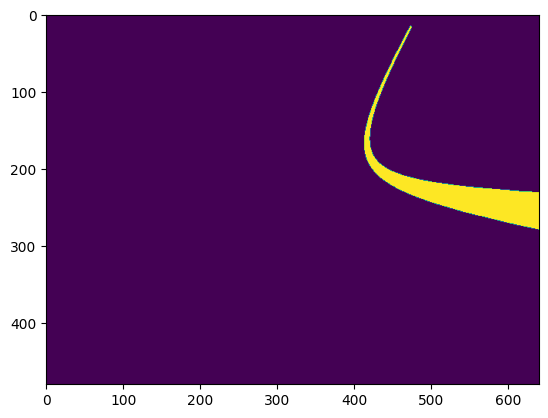

In [57]:
plt.imshow(img_ref_binary)

In [58]:
build_bezier = ConstructionBezier()
build_bezier.to(gpu_or_cpu)
build_bezier.loadRawImage(img_save_path)
build_bezier.getBezierCurveCylinder(p_start, para_init)
build_bezier.getCylinderMeshProjImg()
build_bezier.getBezierProjImg()
# build_bezier.draw2DCylinderImage(image_ref, save_img_path)

In [59]:
bezier_proj_img = build_bezier.bezier_proj_img.detach().numpy()
bezier_proj_centerline_img = build_bezier.bezier_proj_centerline_img.detach().numpy()
print("Shape of bezier_proj_img", bezier_proj_img.shape)
print("Shape of bezier_proj_centerline_img", bezier_proj_centerline_img.shape)
img_render_point_cloud = bezier_proj_img.reshape(bezier_proj_img.shape[0] * bezier_proj_img.shape[1], 2)
print("Shape of img_render_point_cloud", img_render_point_cloud.shape)

Shape of bezier_proj_img (30, 30, 2)
Shape of bezier_proj_centerline_img (30, 2)
Shape of img_render_point_cloud (900, 2)


Projected tip (473, 16)


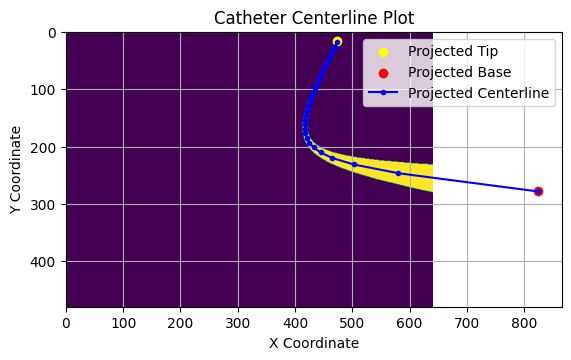

In [60]:
projected_base = (int(bezier_proj_centerline_img[1, 0]), int(bezier_proj_centerline_img[1, 1]))
projected_tip = (int(bezier_proj_centerline_img[-1, 0]), int(bezier_proj_centerline_img[-1, 1]))
print("Projected tip", projected_tip)

x = bezier_proj_centerline_img[1:, 0]
y = bezier_proj_centerline_img[1:, 1]

# 绘制这些坐标点
# plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)

plt.scatter(projected_tip[0], projected_tip[1], color='yellow', label='Projected Tip')  
plt.scatter(projected_base[0], projected_base[1], color='red', label='Projected Base')

plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Centerline', markersize=3)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Catheter Centerline Plot')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
mask = (img_render_point_cloud[:, 0] >= 0) & (img_render_point_cloud[:, 0] <= 640) & (img_render_point_cloud[:, 1] >= 0) & (img_render_point_cloud[:, 1] <= 480)
img_render_point_cloud = img_render_point_cloud[mask]
print("Shape of img_render_point_cloud after mask", img_render_point_cloud.shape)

num_points = 200
n = img_render_point_cloud.shape[0]
step = n // num_points
indices = np.arange(0, n, step)
img_render_point_cloud = img_render_point_cloud[indices]

Shape of img_render_point_cloud after mask (840, 2)


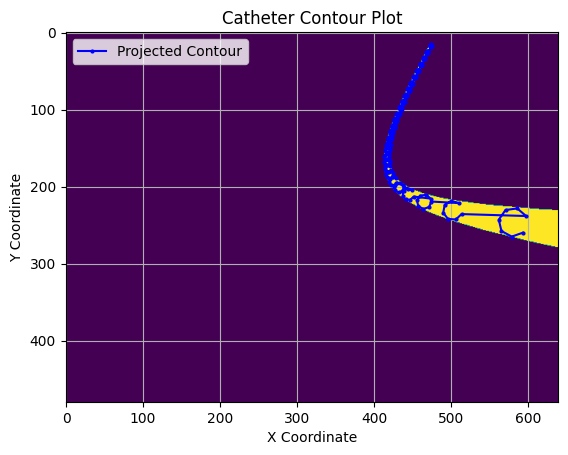

In [62]:
x = img_render_point_cloud[1:, 0]
y = img_render_point_cloud[1:, 1]

# 绘制这些坐标点
# plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Contour', markersize=2)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Catheter Contour Plot')
plt.legend()
plt.grid(True)
plt.show()

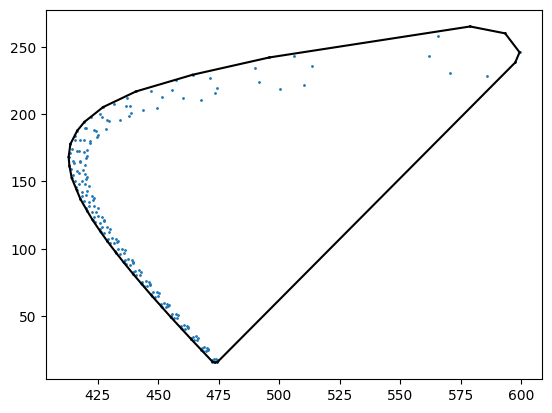

In [63]:
from scipy.spatial import ConvexHull

# 计算凸包
hull = ConvexHull(img_render_point_cloud)

# 绘制点云和凸包
plt.plot(img_render_point_cloud[:, 0], img_render_point_cloud[:, 1], 'o', markersize=1)
for simplex in hull.simplices:
    plt.plot(img_render_point_cloud[simplex, 0], img_render_point_cloud[simplex, 1], 'k-')

# 显示结果
plt.show()